# Homework 1

## Physics 7810
## Due January 27, 2020

## H1.1 - Ordinary differential equation (ODE) solvers

In the first tutorial, you solved the equations of motion for the 1D simple harmonic oscillator (SHO) using various simple integration algorithms (Euler, symplectic Euler, and velocity Verlet). This is an example of an *initial value problem*. A number of sophisticated, general-purpose ODE solvers exist to solve such problems, based on algorithms such as the Runge-Kutta and predictor-corrector methods, with enhancements such as variable step size and Richardson extrapolation to control and maintain accuracy.

While symplectic integrators such as velocity Verlet are well-suited for Hamiltonian systems (where the energy is conserved), these more general ODE solvers are typically the methods of choice for solving systems of differential equations where there is no conserved energy or Hamiltonian.

Revisit the 1D SHO, and solve the equations of motion using one of these general purpose methods (the widely used implicit Runge-Kutta method of order 5(4) (RK45) might be a good choice). A number of ODE solvers (including RK45) are available in the `scipy.integrate` library, which can be imported using `import scipy.integrate as integrate`.

As a reminder, Hamilton's equations of motion for the 1D SHO are:

$$\dot{X} = \frac{\partial \cal{H}}{\partial P} = P$$

$$\dot{P} = - \frac{\partial \cal{H}}{\partial X} = - X,$$

Write a python program to integrate these equations of motion using RK45 (`scipy.integrate.RK45`) and compare the results with those obtained using the velocity Verlet algorithm on both short timescales (a few periods of oscillation) and very long timescales (thousands of periods of oscillation), e.g., by making phase space plots and energy plots. Is the RK45 algorithm stable, or does the energy drift over long timescales? Compare the relative short-time accuracies of RK45 and velocity Verlet by measuring the amplitude (standard deviation) of energy fluctuations about the exact value ($E = 1$).

### Solution
To improve the flexibility of the code, in the folder `CompPhysLib`, I wrote a Python library `SHO_integrators.py` for solving problems in Tutorial_01 and Homework_01 here, which can be imported as below.

In [4]:
import numpy as np
import sys
sys.path.insert(1, '../')
from CompPhysLib.SHO_integrators import SHO_integrators
from scipy.integrate import solve_ivp

<Figure size 432x288 with 0 Axes>

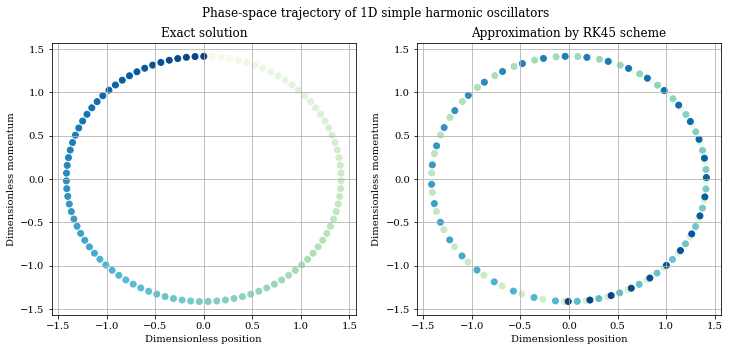

<Figure size 432x288 with 0 Axes>

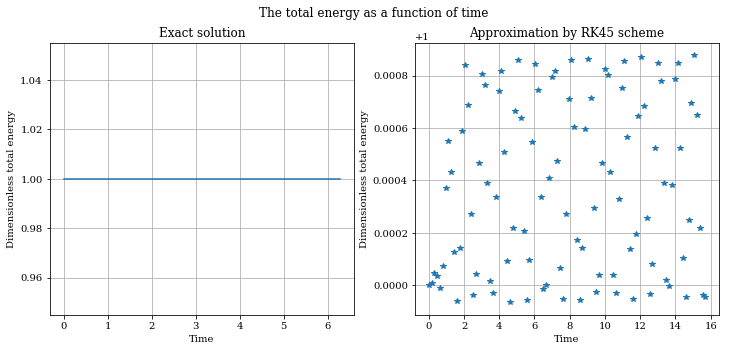

In [52]:
def SHO(t, z):
    x, p = z          # z: vector of the state variable
    return [p, -x]    # dx/dt = p, dp/dx = -x

t = np.linspace(0, 5 * np.pi, 100)  # range of time to integrate
x_0, p_0 = 0, np.sqrt(2)

# solve_ivp(func, t_span, y0, ...)
sol = solve_ivp(SHO, [0, 5*np.pi], [x_0, p_0], dense_output=True)
z = sol.sol(t)   # x(t) = z[0], p(t) = z[1]
x_rk45, p_rk45 = z[0], z[1]

SI = SHO_integrators()
SI.integrator = 'RK45'
SI.dt = t[-1] - t[-2]





SI.SHO_plots(x_rk45, p_rk45)

## H1.2 - Motion in a central force potential

Write a python program to simulate the motion of a particle in a central force potential in two dimensions. Take the form of the potential to be

$$
U({\bf r}) = u r^n,
$$

where ${\bf r} = (x,y)$ is the 2D position of the particle, $r = |{\bf r}|$, and $n$ is a positive integer.

First write down the Hamiltonian for this system, and derive Hamilton's equations of motion. Then use the velocity Verlet algorithm to numerically integrate the equations of motion for a few specific cases, say $n = 2$ (2D simple harmonic oscillator) and $n = 4$. Adjust the timestep to ensure good energy conservation, and plot the trajectory of the particle in the $x-y$ plane for various initial conditions. Verify that the particle has the expected elliptical orbit for $n = 2$, and explore how the nature of the orbit changes with varying $n$.

A basic result from classical mechanics is the *virial theorem*, which relates the average kinetic energy $\langle K \rangle$ and the average potential energy $\langle U \rangle$ for a single particle in a central force potential,

$$
\langle K \rangle = \frac{n}{2} \langle U \rangle,
$$

where the angle brackets denote an average over an integral number of periods of the motion, or over a sufficiently long timescale that the averages converge to well-defined values (many periods of motion).

Verify the virial theorem for a few specific values of $n$, by calculating $\langle K \rangle$ and $\langle U \rangle$ from long simulation trajectories.

Repeat these steps for a central force potential of the form

$$
U({\bf r}) = - u r^{-n},
$$

where $n$ is a positive integer. Of particular interest is the case $n = 1$ (gravitational or Coulomb potential).